##### The data set used in this project was downloaded from the UCI Machine Learning Repository. The data set consist of health news from various top news agencies on twitter.
##### The first stage of the project was the use of Unsupervised Learning for putting the tweets into groups/clusters. Which was then used as the target variables for the classification stage(Supervised Learning).
##### K-Means was used for Clustering due to its simplicity and for Classifiaction a Naiyes Bayes Classifier was used also because of its simplicity 

# CLUSTERING

In [2]:
# importing the needed libraries
import numpy as np
import pandas as pd
import string
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud, ImageColorGenerator 
from glob import glob
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# function for importing the .txt files
def import_txt_files(route):
    dataframe = pd.read_csv(route, sep="|", header=None, names=["id", "timestamp", "tweet"],
                            encoding="mac_latin2", on_bad_lines="skip")
    return dataframe

In [3]:
# importing the files
files = glob("./Health-Tweets/*.txt")
files

['./Health-Tweets\\bbchealth.txt',
 './Health-Tweets\\cbchealth.txt',
 './Health-Tweets\\cnnhealth.txt',
 './Health-Tweets\\everydayhealth.txt',
 './Health-Tweets\\foxnewshealth.txt',
 './Health-Tweets\\gdnhealthcare.txt',
 './Health-Tweets\\goodhealth.txt',
 './Health-Tweets\\KaiserHealthNews.txt',
 './Health-Tweets\\latimeshealth.txt',
 './Health-Tweets\\msnhealthnews.txt',
 './Health-Tweets\\NBChealth.txt',
 './Health-Tweets\\nprhealth.txt',
 './Health-Tweets\\nytimeshealth.txt',
 './Health-Tweets\\reuters_health.txt',
 './Health-Tweets\\usnewshealth.txt',
 './Health-Tweets\\wsjhealth.txt']

## Data Preprocessing

In [4]:
# concatenating the files
df = pd.concat([import_txt_files(file) for file in files])
df.head()

id                       timestamp  \
0  585978391360221184  Thu Apr 09 01:31:50 +0000 2015   
1  585947808772960257  Wed Apr 08 23:30:18 +0000 2015   
2  585947807816650752  Wed Apr 08 23:30:18 +0000 2015   
3  585866060991078401  Wed Apr 08 18:05:28 +0000 2015   
4  585794106170839041  Wed Apr 08 13:19:33 +0000 2015   

                                               tweet  
0  Breast cancer risk test devised http://bbc.in/...  
1  GP workload harming care - BMA poll http://bbc...  
2  Short people's 'heart risk greater' http://bbc...  
3  New approach against HIV 'promising' http://bb...  
4  Coalition 'undermined NHS' - doctors http://bb...

In [5]:
# shape of the data set
df.shape

(62817, 3)

In [6]:
# function for removing unwanted characters from the tweet column
def preprocess_dataframe(dataf):
    dataf["tweet"] = dataf["tweet"].str.replace("RT ", " ") # remove RT tag
    dataf["tweet"] = dataf["tweet"].str.replace("\&\w*;", " ", regex=True) # Remove any special characters starting with '&' in the tweet column
    dataf["tweet"] = dataf["tweet"].str.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)",
                                                " ", regex=True) # remove mentions, special characters, URLs, and digits
    dataf["tweet"] = dataf["tweet"].str.rstrip(" ") # removes any trailing whitespace at the right end
    dataf["tweet"] = dataf["tweet"].str.lstrip(" ") # removes any leading whitespace at the left end
    
    return dataf

In [7]:
# applying the preprocess_dataframe function on the dataset
preprocessed_dataset = preprocess_dataframe(df)
preprocessed_dataset.head()

id                       timestamp  \
0  585978391360221184  Thu Apr 09 01:31:50 +0000 2015   
1  585947808772960257  Wed Apr 08 23:30:18 +0000 2015   
2  585947807816650752  Wed Apr 08 23:30:18 +0000 2015   
3  585866060991078401  Wed Apr 08 18:05:28 +0000 2015   
4  585794106170839041  Wed Apr 08 13:19:33 +0000 2015   

                                  tweet  
0       Breast cancer risk test devised  
1   GP workload harming care   BMA poll  
2    Short people s  heart risk greater  
3   New approach against HIV  promising  
4  Coalition  undermined NHS    doctors

In [8]:
# Shuffling the dataset
preprocessed_dataset = preprocessed_dataset.sample(frac=1, ignore_index=True, random_state=42)
preprocessed_dataset.head()

id                       timestamp  \
0  560332715606544384  Wed Jan 28 07:05:04 +0000 2015   
1  505677336625176577  Sat Aug 30 11:24:06 +0000 2014   
2  124873351561875457  Fri Oct 14 15:45:01 +0000 2011   
3  562391998624464896  Mon Feb 02 23:27:55 +0000 2015   
4  468198569636155393  Mon May 19 01:16:52 +0000 2014   

                                               tweet  
0  Find out what healthcare leaders think to Labo...  
1  New Novartis heart failure drug cuts risk by a...  
2  QuickPick  What s your favorite quickie workou...  
3  Processed foods for America s youngest eaters ...  
4         Melinda Gates Works to Curb Newborn Deaths

In [9]:
def get_top_100_words(data, display=False):
    """display the top 100 most frequent words"""
    
    # Split the text into words and create a Series
    words = data.str.split().explode()
    # Count the frequency of each word
    word_counts = words.value_counts()
    # Create a new DataFrame with the top 100 most frequent words and their counts
    top_100_words = word_counts.head(100).reset_index(name='count')
    
    if display:
        # display the words frequencies before stopwords removal
        return px.bar(x=top_100_words["tweet"], y=top_100_words["count"], data_frame=top_100_words,
                       color=top_100_words["count"], color_continuous_scale="Jet", text=top_100_words["tweet"],
                       title="Top 100 Most Frequent Words")
    else:
        # return a dataframe of the top 100 frequent words
        return top_100_words

In [10]:
# display the words frequencies before stopwords removal
get_top_100_words(preprocessed_dataset["tweet"], display=True)

In [11]:
# stopwords list
stopwords = stopwords.words("english")
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [12]:
# list of custom stopwords
new_stopwords = ["new", "say", "like", "ways", "make", "says", "video", "day", "try", "use", "year", "today",
                 "need", "know", "report", "plan", "plans", "big", "help", "take", "see", "may", "get", "costs",
                 "care", "deal","sector","tell", "suspected", "india", "wants","california", "cost", "happy",
                 "help", "risk", "drug", "well", "via", "one", "could", "people", "kids", "finds", "fast",
                 "good", "life", "time", "works", "work", "reports", "best", "many", "want", "linked", "still",
                 "back", "tips", "high", "might", "week", "loss", "find", "linked", "sign", "cost", "first", 
                 "need","every", "cases","officials","exchange","exchanges","toll","ways","work", "airport",
                 "say","like","sign", "eating", "even", "likely", "read", "years", "start", "easy", "early",
                 "news", "things", "shows", "long", "join", "would", "look", "getting", "think", "much", "keep",
                 "free", "common", "world", "states", "great", "stop", "thanks", "without", "little", "change",
                 "watch", "next", "rules", "lose", "right", "really", "less", "questions", "better", "canada",
                 "study", "must", "last", "weekend", "rates", "state", "give", "data", "last", "lower", "helps",
                 "going", "problems", "call", "raises", "raise", "gets", "get", "among", "stay","first", " rt ",
                 "latest", "show", "could", "holiday", "miss", "found", "awaits", "helping", "seats", "story",
                 "rushes", "makes","sharing", "looking", "worst", "swaps", "choices", "training", "west",
                 "strict", "treat", "diet", "higher", "fight", "fighting", "newsletter", "second", "moves",
                 "newsletters", "working", "headlines", "tied", "fall", "step",  "longer", "list", "possible", 
                 "contain", "making", "house", "support", "talk", "million", "atlanta", "texas", "millions",
                 "avoid", "survivors", "survivor", "death", "fear", "chief", "small", "body", "medical", "home", 
                 "victim", "spanish", "declares", "dies", "team", "british", "dallas", "online", "thousands",
                 "trial", "home", "check", "cause", "face", "daily", "staff", "share", "feel", "hundreds",
                 "improve", "american", "deaths", "death", "america", "americans", "blog", "case","changes",
                 "changing", "http", "got", "way", "two", "let"]

In [13]:
# extending stopword list
stopwords.extend(new_stopwords)
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [14]:
#function to get rid of stopwords present in the messages
def remove_stopwords(tweet):
    clean_words = [word.lower() for word in tweet.split() if word.lower() not in stopwords and len(word)>=3]
    return " ".join(clean_words)

In [15]:
# apply the remove_stopwords function
preprocessed_dataset['tweet'] = preprocessed_dataset['tweet'].apply(remove_stopwords)

In [8]:
# stemmatizing function
#stemmer = SnowballStemmer()
#def stemmatizer(tweet):
#    stemmatized_words = [stemmer.stem(word) for word in word_tokenize(tweet)]
#    return " ".join(stemmatized_words)

In [9]:
# apply the stemmatizing function
#preprocessed_dataset["tweet"] = preprocessed_dataset["tweet"].apply(stemmatizer)
#preprocessed_dataset.head()

In [16]:
# lemmatizing function
wnl = WordNetLemmatizer()
def lemmatizer(tweet):
    lemmatized_words = [wnl.lemmatize(word) for word in word_tokenize(tweet)]
    return " ".join(lemmatized_words)

In [17]:
# apply the lemmatizing function
preprocessed_dataset["tweet"] = preprocessed_dataset["tweet"].apply(lemmatizer)
preprocessed_dataset.head()

id                       timestamp  \
0  560332715606544384  Wed Jan 28 07:05:04 +0000 2015   
1  505677336625176577  Sat Aug 30 11:24:06 +0000 2014   
2  124873351561875457  Fri Oct 14 15:45:01 +0000 2011   
3  562391998624464896  Mon Feb 02 23:27:55 +0000 2015   
4  468198569636155393  Mon May 19 01:16:52 +0000 2014   

                                               tweet  
0                        healthcare leader labour nh  
1                   novartis heart failure cut fifth  
2            quickpick favorite quickie workout vote  
3  processed food youngest eater pave cardiovascu...  
4                          melinda gate curb newborn

In [18]:
# counting the words frequencies after stopwords removal and stemming
get_top_100_words(preprocessed_dataset["tweet"], display=True)

In [19]:
# sum of null values
preprocessed_dataset.isnull().sum()

id           0
timestamp    0
tweet        0
dtype: int64

## Feature Engineering

In [20]:
# feature extraction using TF-IDF
vectorizer = TfidfVectorizer(stop_words=stopwords, analyzer="word",
                             tokenizer=word_tokenize, max_df=0.9)
features = vectorizer.fit_transform(preprocessed_dataset["tweet"])

In [21]:
features.shape

(62817, 22196)

In [22]:
# dimensionality reduction using TruncatedSVD since we are dealing with sparse matrix
svd = TruncatedSVD(100)
pipeline = make_pipeline(svd, Normalizer())
reduced_features = pipeline.fit_transform(features)

In [23]:
reduced_features.shape

(62817, 100)

## Model Training

*I tried different number of clusters and 6 gave the best result*

In [30]:
num_clusters = 6
km = KMeans(num_clusters, max_iter=100)
clusters = km.fit_predict(reduced_features)

## visualisation
#### I used  only the first 3000 samples for visualization

In [31]:
# dimensionality reduction for visualisation
pca = PCA(n_components=2)
v_reduced_feature = pca.fit_transform(features[:1000].toarray())

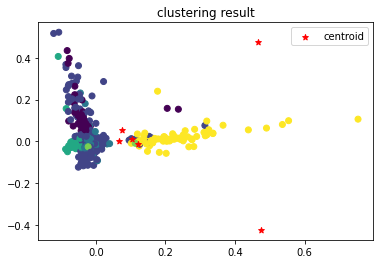

In [32]:
# visualising the feature clusters
plt.scatter(v_reduced_feature[:,0], v_reduced_feature[:,1], c=clusters[:1000], cmap="viridis")
plt.scatter(km.cluster_centers_[:,0],  km.cluster_centers_[:,1], color="red", marker="*", label="centroid")
plt.title("clustering result")
plt.legend(loc="upper right")

*The graph shows that the model did a bit well*


Most discriminative words per cluster:
Cluster 0: 


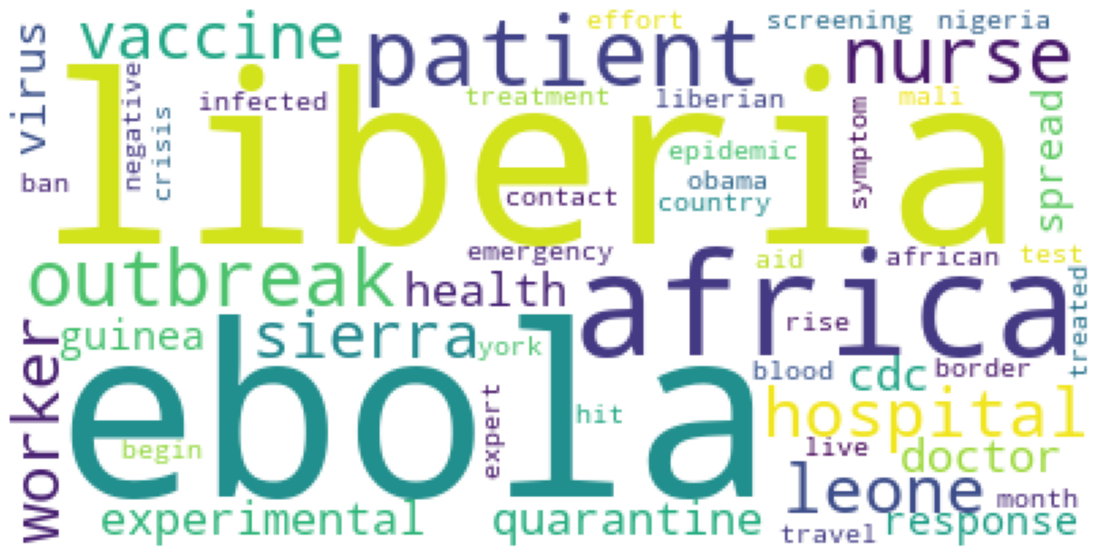





Cluster 1: 


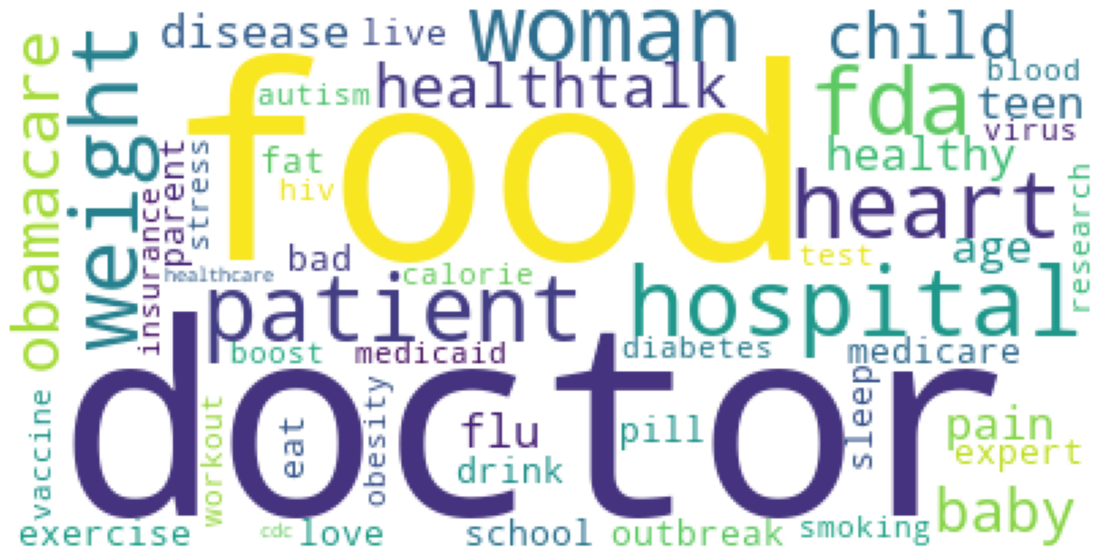





Cluster 2: 


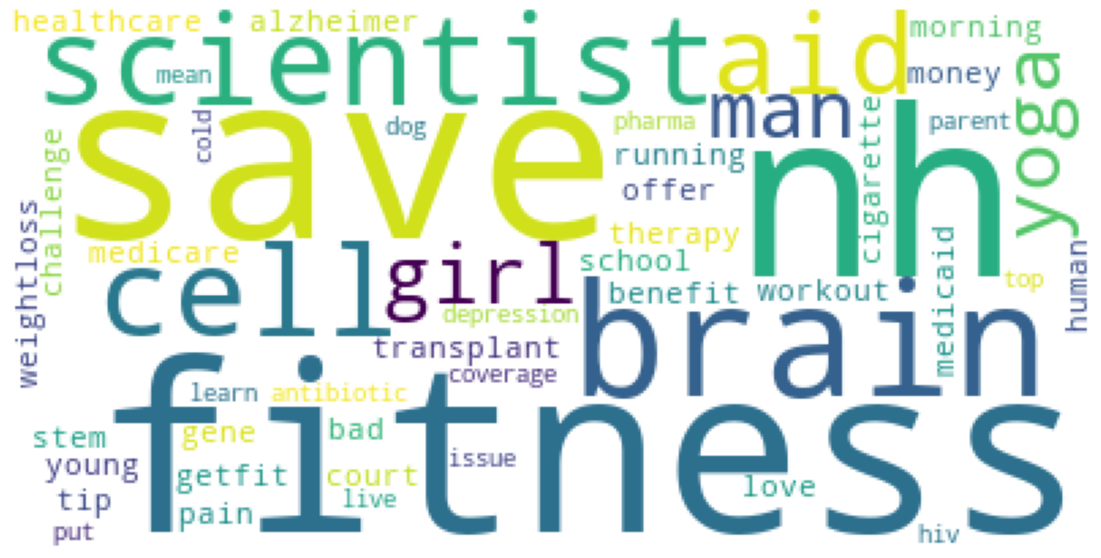





Cluster 3: 


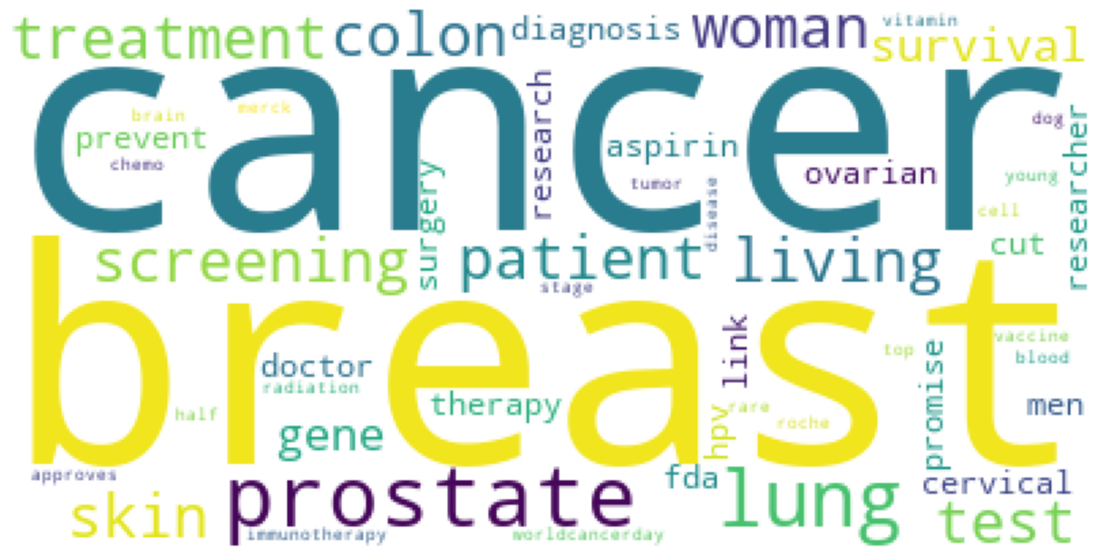





Cluster 4: 


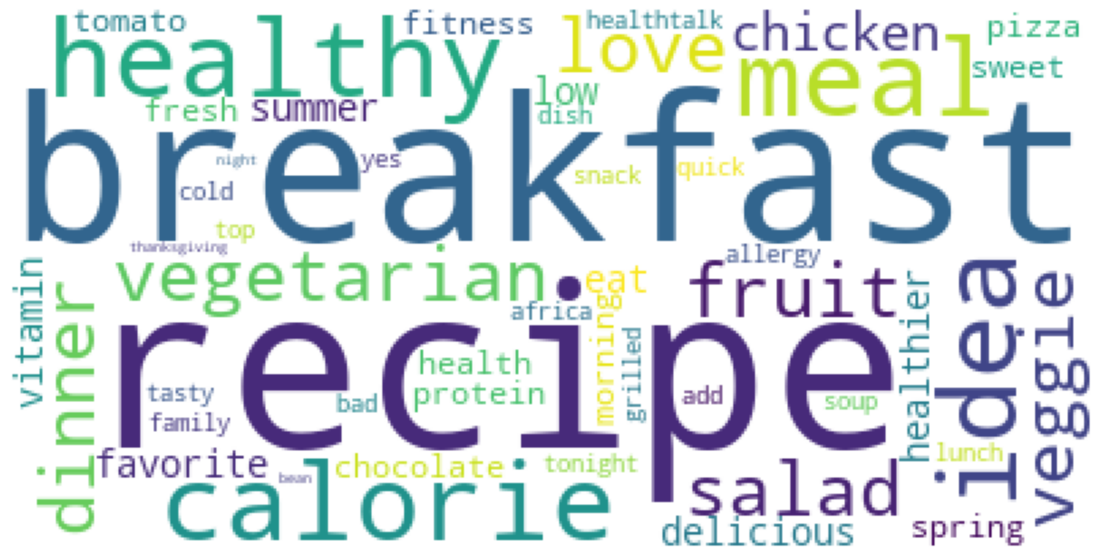





Cluster 5: 


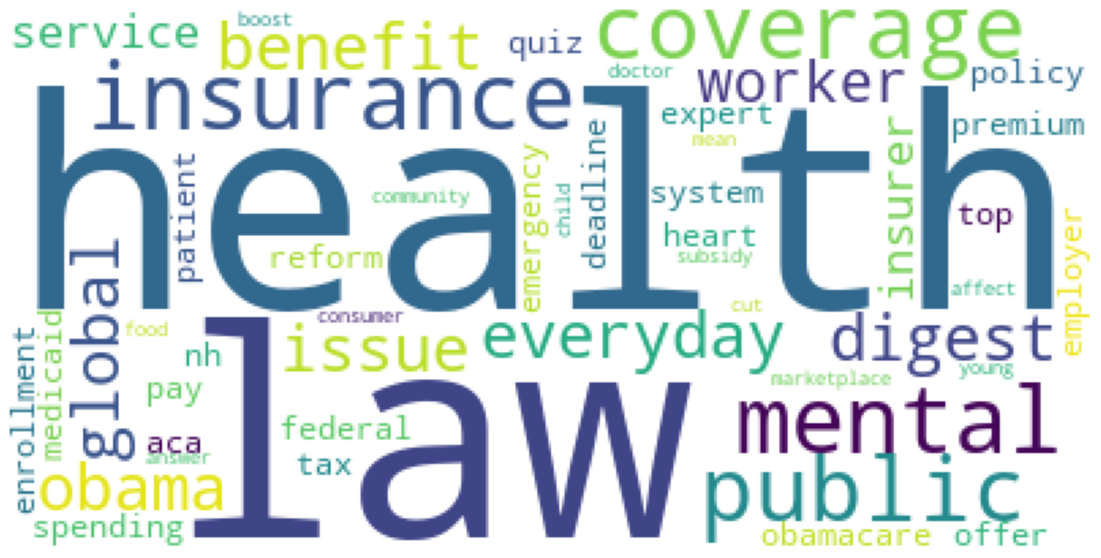

In [33]:
# function to isualize wordclusters in wordcloud
def evaluate(km, svd, num_clusters):
    print("\nMost discriminative words per cluster:")
    original_space_centroids = svd.inverse_transform(km.cluster_centers_) # get the inverse transform of the cluster centers
    order_centroids = original_space_centroids.argsort()[:, ::-1] # sort
    terms = vectorizer.get_feature_names_out() # get words from the vectorizer
    for i in range(num_clusters):
        print("Cluster " + str(i) + ": ")
        cl_terms = ""
        # get first 50 words of each clusters
        for ind in order_centroids[i, :50]:
            cl_terms += terms[ind] + " "
        # visualize in word cloud    
        wordcloud = WordCloud(collocations=False, background_color="white").generate_from_text(cl_terms)
        plt.figure(figsize=(20,10))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        print("\n\n\n")
evaluate(km, svd, num_clusters)

In [34]:
# assigning the predicted clusters to the tweets
preprocessed_dataset["cluster"] = clusters
preprocessed_dataset.head()

id                       timestamp  \
0  560332715606544384  Wed Jan 28 07:05:04 +0000 2015   
1  505677336625176577  Sat Aug 30 11:24:06 +0000 2014   
2  124873351561875457  Fri Oct 14 15:45:01 +0000 2011   
3  562391998624464896  Mon Feb 02 23:27:55 +0000 2015   
4  468198569636155393  Mon May 19 01:16:52 +0000 2014   

                                               tweet  cluster  
0                        healthcare leader labour nh        2  
1                   novartis heart failure cut fifth        1  
2            quickpick favorite quickie workout vote        1  
3  processed food youngest eater pave cardiovascu...        1  
4                          melinda gate curb newborn        1

In [35]:
# view first 5 cluster zero data
preprocessed_dataset[preprocessed_dataset["cluster"] == 0].head()

id                       timestamp  \
8   506534294286630913  Mon Sep 01 20:09:21 +0000 2014   
34  522810330922360832  Thu Oct 16 18:04:30 +0000 2014   
36  481201530578948096  Mon Jun 23 22:25:59 +0000 2014   
60  497056321771151360  Wed Aug 06 16:27:16 +0000 2014   
81  522423139712913410  Wed Oct 15 16:25:57 +0000 2014   

                                                tweet  cluster  
8       ebola outbreak take tool africa health worker        0  
34                             effort stem ebola tide        0  
36  ebola epidemic control field relief worker ground        0  
60  cigarette maker reynolds hand ebola treatment ...        0  
81    nurse ebola traveled plane cleveland fort worth        0

In [36]:
# view first 5 cluster one data
preprocessed_dataset[preprocessed_dataset["cluster"] == 1].head()

id                       timestamp  \
1  505677336625176577  Sat Aug 30 11:24:06 +0000 2014   
2  124873351561875457  Fri Oct 14 15:45:01 +0000 2011   
3  562391998624464896  Mon Feb 02 23:27:55 +0000 2015   
4  468198569636155393  Mon May 19 01:16:52 +0000 2014   
6  329996134539984896  Thu May 02 16:29:44 +0000 2013   

                                               tweet  cluster  
1                   novartis heart failure cut fifth        1  
2            quickpick favorite quickie workout vote        1  
3  processed food youngest eater pave cardiovascu...        1  
4                          melinda gate curb newborn        1  
6             arkansas medicaid model private option        1

In [37]:
# view first 5 cluster two data
preprocessed_dataset[preprocessed_dataset["cluster"] == 2].head()

id                       timestamp  \
0   560332715606544384  Wed Jan 28 07:05:04 +0000 2015   
7   535750743639080960  Fri Nov 21 11:05:05 +0000 2014   
12  469163802156892161  Wed May 21 17:12:21 +0000 2014   
14  299270789683896323  Wed Feb 06 21:38:11 +0000 2013   
15  413344320650240000  Wed Dec 18 16:25:40 +0000 2013   

                                                tweet  cluster  
0                         healthcare leader labour nh        2  
7                    impact berwick nh patient safety        2  
12  explains takeover limit pfe offer azn also all...        2  
14                                       living break        2  
15                      brain injury concern baseball        2

In [38]:
# view first 5 cluster three data
preprocessed_dataset[preprocessed_dataset["cluster"] == 3].head()

id                       timestamp  \
5    407458658419605504  Mon Dec 02 10:38:09 +0000 2013   
63   172012579273707521  Tue Feb 21 17:39:29 +0000 2012   
92   528940582467825664  Sun Nov 02 16:03:56 +0000 2014   
113  539252872794226688  Mon Dec 01 03:01:18 +0000 2014   
170  393828282124468224  Fri Oct 25 19:55:54 +0000 2013   

                                                 tweet  cluster  
5                               cancer tough worse dad        3  
63                       fda head shortage cancer drug        3  
92   breakthrough expected diagnosis prostate cance...        3  
113                                 screen cancer gene        3  
170                     husband gps wife breast cancer        3

In [39]:
# view first 5 cluster four data
preprocessed_dataset[preprocessed_dataset["cluster"] == 4].head()

id                       timestamp  \
29  350338409115553793  Thu Jun 27 19:42:40 +0000 2013   
30  331444735833145344  Mon May 06 16:25:57 +0000 2013   
48  502849545622278144  Fri Aug 22 16:07:28 +0000 2014   
51  402643697898385408  Tue Nov 19 03:45:12 +0000 2013   
94   95569137132253185  Mon Jul 25 19:00:32 +0000 2011   

                                                tweet  cluster  
29       pas white spoon color cutlery perceive taste        4  
30  sick old turkey wheat spice lunch healthy sand...        4  
48                              vegetarian taco night        4  
51                            vegetarian thanksgiving        4  
94  recipe meal planning favorite easily prepare m...        4

In [40]:
# view first 5 cluster five data
preprocessed_dataset[preprocessed_dataset["cluster"] == 5].head()

id                       timestamp  \
16   355080854764134400  Wed Jul 10 21:47:27 +0000 2013   
26   422765500142084096  Mon Jan 13 16:22:04 +0000 2014   
74   426843114108882944  Fri Jan 24 22:25:03 +0000 2014   
77   342133966402363392  Wed Jun 05 04:21:08 +0000 2013   
125  375109564926267392  Wed Sep 04 04:14:24 +0000 2013   

                                                 tweet  cluster  
16                        gop delay health law forever        5  
26                                   health retirement        5  
74                      set roadblock health navigator        5  
77                fukushima tuna miniscule health risk        5  
125  experimental seems erase negative health conse...        5

# CLASSIFICATION

## Feature Engineering

In [41]:
# dropping unwanted
preprocessed_dataset = preprocessed_dataset.drop(["id","timestamp"], axis=1)

In [42]:
# number of samples of each cluster
preprocessed_dataset["cluster"].value_counts()

cluster
1    35472
2    13656
5     4756
0     4366
3     2429
4     2138
Name: count, dtype: int64

In [43]:
# handling data imbalnce by selecting 5000 samples of the clusters
# the with the most samples
cluster_0 = preprocessed_dataset[preprocessed_dataset["cluster"]==0]
cluster_1 = preprocessed_dataset[preprocessed_dataset["cluster"]==1][:5000]
cluster_2 = preprocessed_dataset[preprocessed_dataset["cluster"]==2][:5000]
cluster_3 = preprocessed_dataset[preprocessed_dataset["cluster"]==3]
cluster_4 = preprocessed_dataset[preprocessed_dataset["cluster"]==4]
cluster_5 = preprocessed_dataset[preprocessed_dataset["cluster"]==5]
cluster_6 = preprocessed_dataset[preprocessed_dataset["cluster"]==6]

In [44]:
# concatenating the different clusters into one dataframe
reshaped_dataset = pd.concat([cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6])
reshaped_dataset = reshaped_dataset.sample(frac=1, ignore_index=True, random_state=42)
reshaped_dataset.head()

tweet  cluster
0                           pledge fund ebola double        0
1  health nutrition expert share fave superfoods ...        5
2  jersey governor christie duck medium vaccinati...        2
3  instead large workout tried exercising snack s...        1
4                                       bacteria fat        1

In [45]:
# features and target variables
X = reshaped_dataset.drop(["cluster"], axis=1)
y = reshaped_dataset["cluster"]

In [46]:
# number of samples in each class 
y.value_counts()

cluster
2    5000
1    5000
5    4756
0    4366
3    2429
4    2138
Name: count, dtype: int64

In [47]:
# initializing the vectorizer
vectorizer = TfidfVectorizer()

In [48]:
# vectorizing the data
X_vec = vectorizer.fit_transform(X["tweet"])

In [49]:
# splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.10, random_state=32)

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (21320, 14612)
y_train shape (21320,)
X_test shape (2369, 14612)
y_test shape (2369,)


## Model Training

In [50]:
#initializing the naiyes bayes classifier
naiyes_clf = MultinomialNB()
naiyes_clf.fit(X_train, y_train)

MultinomialNB()

## Model Evaluation

In [51]:
# train accuracy
naiyes_clf.score(X_train, y_train)

0.9200750469043152

In [52]:
# test accuracy
naiyes_clf.score(X_test, y_test)

0.8172224567327987

In [53]:
# predictions
y_pred = naiyes_clf.predict(X_test)
y_pred

array([3, 3, 0, ..., 3, 3, 1])

In [54]:
#printing classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       458
           1       0.73      0.68      0.71       475
           2       0.79      0.74      0.76       487
           3       0.94      0.83      0.88       244
           4       0.91      0.82      0.86       213
           5       0.77      0.87      0.82       492

    accuracy                           0.82      2369
   macro avg       0.84      0.82      0.83      2369
weighted avg       0.82      0.82      0.82      2369



These shows that the model performs well with high precision, recall, and F1-Scores for all classes, and it maintains its performance even when considering the class slight imbalances in the dataset.

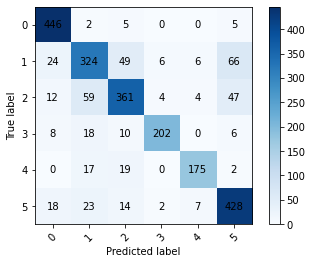

In [55]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm,interpolation='none',cmap='Blues')
plt.colorbar()
tick_marks = np.arange(num_clusters)
plt.xticks(tick_marks, rotation=45)
plt.yticks(tick_marks)

for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.show()

Overall this indicates that the model has a relatively good performance but there is room for improvement.